In [1]:
from textblob import TextBlob
import os
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import pearsonr, f_oneway
import statsmodels.api as sm
import pandas as pd

In [2]:
albums = ["Taylor Swift", "Fearless (Taylor's Version)", "Speak Now (Taylor's Version)", 
          "Red (Taylor's Version)", "1989 (Taylor's Version)", "reputation", "Lover", 
          "folklore", "evermore", "Midnights", "The Tortured Poets Department"]

shortenings = ["Debut", "Fearless", "Speak Now", 
          "Red", "1989", "rep", "Lover", 
          "folklore", "evermore", "Midnights", "TTPD"]

In [3]:

def getPolarity(text):
    return TextBlob(text).sentiment.polarity

def getAnalysis(score):
    if score < 0:
        return -1
    elif score > 0:
        return 1
    else:
        return 0

In [4]:
if __name__ == "__main__":

    sentiment_class = {}
    # Iterates over all of the directories
    for root, dirs, files in os.walk('songs_excl_ftv', topdown=True):

        for dir in dirs:
            sentiment_class[dir] = {}
            for file in os.listdir(os.path.join("songs_excl_ftv/", dir)):
                title = os.path.join(f"songs_excl_ftv/{dir}", file)
                with open(title) as t:
                    sentiment_class[dir][file[0:file.index(".")]] = {}
                    content = t.read()
                    sentiment = getPolarity(content)
                    sentiment = getAnalysis(sentiment)
                    sentiment_class[dir][file[0:file.index(".")]] = sentiment

    positives = []
    negatives = []
    neutrals = []
    for album in albums:
        pos_counts = 0
        neg_counts = 0
        neut_counts = 0
        for song in sentiment_class[album]:
            if sentiment_class[album][song] == 1:
                pos_counts += 1
            elif sentiment_class[album][song] == -1:
                neg_counts += 1
            else:
                neut_counts += 1
        positives.append(pos_counts)
        negatives.append(neg_counts)
        neutrals.append(neut_counts)
        


In [5]:
print(positives)
print(negatives)
print(neutrals)

[10, 14, 12, 18, 12, 8, 13, 10, 14, 18, 19]
[4, 6, 4, 2, 5, 7, 6, 7, 3, 4, 12]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [6]:
num_of_songs = [14, 20, 16, 20, 17, 15, 19, 17, 17, 22, 31]

negatives = list(negatives)
neutrals = list(neutrals)
positives = list(positives)

for i, neg in enumerate(negatives):
    negatives[i] = neg / num_of_songs[i]

for i, pos in enumerate(positives):
    positives[i] = pos / num_of_songs[i]

for i, neu in enumerate(neutrals):
    neutrals[i] = neu / num_of_songs[i]

negatives = np.array(negatives)
positives = np.array(positives)
neutrals = np.array(neutrals)

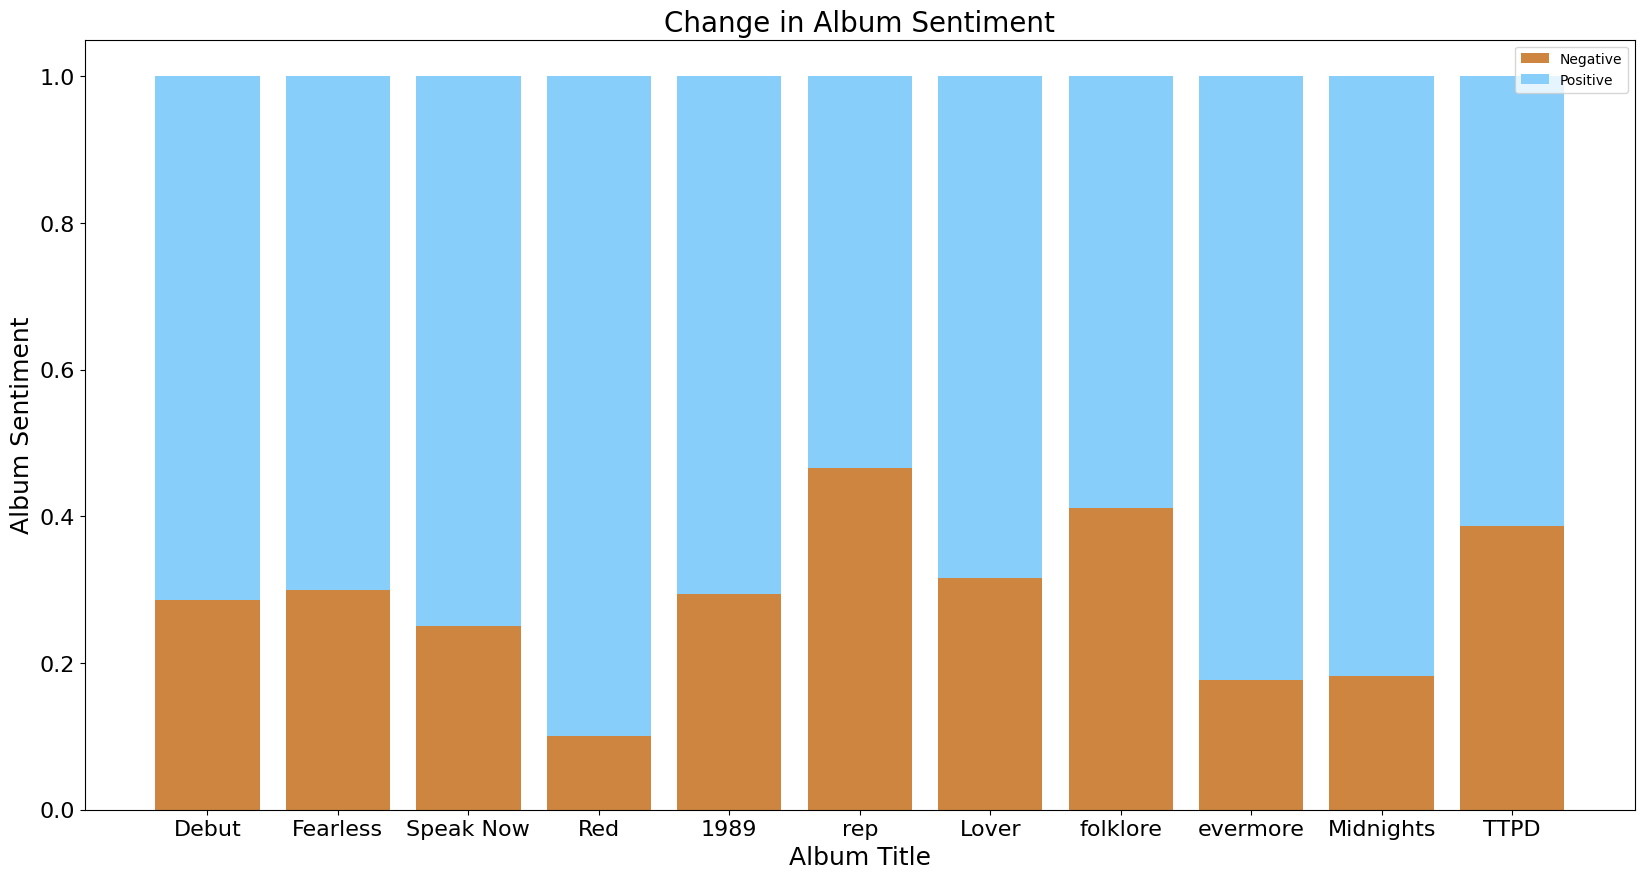

In [7]:
plt.figure(figsize=(20, 10))

plt.bar(shortenings, negatives, color='peru', label='Negative')
# plt.bar(shortenings, neutrals, bottom = negatives, color = 'thistle', label = 'Neutral')
plt.bar(shortenings, positives, bottom = negatives + neutrals, color='lightskyblue', label="Positive")

plt.tick_params(axis="both", which='major', labelsize="16")

plt.title("Change in Album Sentiment", fontsize='20')
plt.xlabel("Album Title", fontsize='18')
plt.ylabel("Album Sentiment", fontsize='18')

plt.legend()
plt.show()

In [8]:
correlation_coefficient, p_value = pearsonr(np.array([2006, 2008, 2010, 2012, 2014, 2017, 2019, 2020, 2020, 2022, 2024]), negatives)

print(correlation_coefficient)
print(p_value)

0.20832402318610715
0.5387487007105911


In [9]:
negatives = list(negatives)


country = [negatives[0], negatives[1], negatives[2]]
country_to_pop = [negatives[3], negatives[4]]
pop = [negatives[5], negatives[6]]
experimental = [negatives[7],negatives[8],negatives[9],negatives[10]]

f_stat, p_value = f_oneway(country, country_to_pop, pop, experimental)
print(f_stat)
print(p_value)

1.1065533847446378
0.4082445211331257


In [10]:
data = {
    "Year": [2006, 2008, 2010, 2012, 2014, 2017, 2019, 2020, 2020, 2022, 2024],
    "Negativity": negatives
}

df = pd.DataFrame(data)
X = df["Year"]
y = df["Negativity"]
X = sm.add_constant(X)
model = sm.OLS(y,X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:             Negativity   R-squared:                       0.043
Model:                            OLS   Adj. R-squared:                 -0.063
Method:                 Least Squares   F-statistic:                    0.4083
Date:                Wed, 11 Dec 2024   Prob (F-statistic):              0.539
Time:                        13:57:17   Log-Likelihood:                 9.5538
No. Observations:                  11   AIC:                            -15.11
Df Residuals:                       9   BIC:                            -14.31
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -7.3251     11.914     -0.615      0.5

/Users/sarahbaskin/miniconda3/envs/cosi114a/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
